# Neural Style Transfer

In [1]:
%matplotlib inline
import importlib
import matplotlib.pyplot as plt
from vgg16 import VGG16
from keras.models import Model
import keras.backend as K
from keras import metrics
from keras.layers import AveragePooling2D
from glob import glob
from PIL import Image
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
path = './data/'

In [3]:
fnames = glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

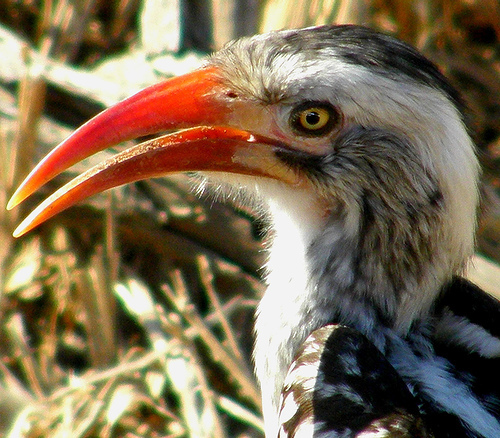

In [4]:
img = Image.open(fnames[502]); img

Images needs to be preprocessed according to the authors of the VGG16.
* subtract the mean of each channel of the imagenet
* reverse the order RGB -> BGR

In [5]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preprocess = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [6]:
deprocess = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [7]:
p = preprocess(np.expand_dims(np.array(img), 0))
p_shape = p.shape; p_shape

(1, 438, 500, 3)

## A Neural Algorithm of Artistic Style
* [paper](https://arxiv.org/abs/1508.06576)

### Approach
1. Content Representation
2. Style Representation

## 1. Content Representation
Recreate an image from noise based on the 'content loss' – the amount of difference between activations in some layer.

1. Pass an image(***p***) through model (VGG16). 
2. Pass a 'noise image' (***x***) through the same model.
3. At some layer ***l***, compare the outputs for both images using MSE.
4. We can change x until it generates the same response in layer l as p

MaxPooling is useful for image classification. It's not useful in this case, since MaxPooling loses information about the original input area. Instead we'll use AveragePooling, as this doesn't throw away as much information.

In [8]:
model = VGG16(include_top=False, int_pooling='avg')

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [10]:
# grab activations near the end of conv model
layer = model.get_layer('block5_conv1').output

In [11]:
# calculate target activations for this layer
layer_model = Model(model.input, layer)
target = K.variable(layer_model.predict(p))

We need to be able to access the loss function and gradients separately, since that is what scikit-learn's optimizers require.

In [12]:
class Evaluator(object):
    def __init__(self, fn, shape): self.fn, self.shape = fn, shape
    
    def loss(self, x):
        loss_, self.grad_values = self.fn([x.reshape(self.shape)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [13]:
loss = K.mean(metrics.mse(layer, target))

In [14]:
grads = K.gradients(loss, model.input)

To obtain output of our intermediate layer we use Keras function

In [15]:
fn = K.function([model.input], [loss]+grads)

In [16]:
evaluator = Evaluator(fn, p_shape)

Optimize loss function with a deterministic approach - line search.

In [17]:
def solve_image(evaluator, n_iterations, x):
    for i in range(n_iterations):
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        
        x = np.clip(x, -127, 127)
        print(f'Current loss value {i}:', min_val)
        img = deprocess(x.copy(), p_shape)[0]
        imsave(f'./results/res_at_iteration_{i}.png', img)
    return x

Generate random image

In [18]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(p_shape)

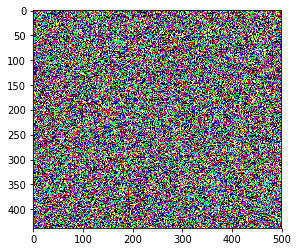

In [19]:
plt.imshow(x[0])

Run optimization

In [20]:
iterations=10

In [21]:
x = solve_image(evaluator, iterations, x)

Current loss value 0: 121.895584106
Current loss value 1: 44.7139205933
Current loss value 2: 27.5896987915
Current loss value 3: 19.7225723267
Current loss value 4: 15.2615776062
Current loss value 5: 12.5651016235
Current loss value 6: 10.7360343933
Current loss value 7: 9.46663665771
Current loss value 8: 8.56241130829
Current loss value 9: 7.83332395554


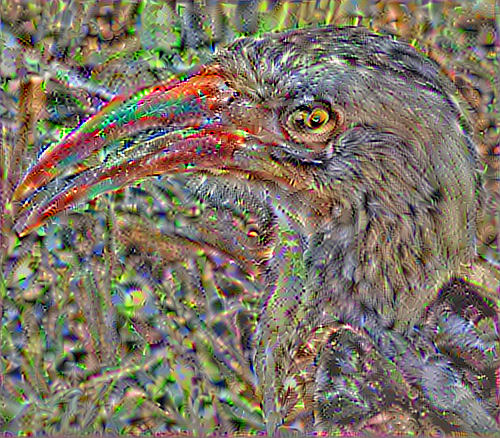

In [22]:
Image.open('./results/res_at_iteration_9.png')

## 2. Style Representation